## 말투 변환

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install datasets transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00


In [3]:
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
)
from tokenizers import Tokenizer
from typing import Dict, List, Optional
from torch.utils.data import Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
from typing import Dict

In [42]:
df = pd.read_excel("/content/drive/MyDrive/text-transfer-data/말투변환_최종.xlsx")
df.head()

,formal,gentle
0,"‘비타민B7’ ‘비타민H’로도 불리는 비오틴은 모발과 피부, 손톱을 건강하게 유지하...","비타민 B7, 또는 비타민 H로 더 알려진 비오틴은 건강한 모발, 피부, 손톱 유지..."
1,"특히 머리카락을 구성하는 단백질인 케라틴 생성에 중요한 역할을 담당하고, 결핍 시 ...","'모발 비타민'은 머리카락을 구성하는 단백질인 케라틴 생성에 주요한 역할을 하며, ..."
2,탈모로 고민하는 사람들 사이에서 특히 이름난 영양소인 비오틴.,"비오틴은 이름난 영양소 중 하나로, 탈모로 고민하는 사람들에게 매우 효과적입니다."
3,비오틴의 역할과 효과 보는 섭취 팁을 소개한다.,"비오틴은 머리와 피부의 건강을 촉진하고 더 긴 두피와 머리카락, 손톱을 유지하기 위..."
4,WHAT: 이름도 생소한 영양소 ‘비오틴’#탈모 보조제의 단골 영양소‘비오틴’이라는...,'비오틴'이라는 단어는 탈모 샴푸나 탈모 보조제 패키지에서 가장 자주 볼 수 있는 ...


In [43]:
df.describe()

,formal,gentle
count,15250,15250
unique,15236,15238
top,안녕하세요.,안녕하십니까
freq,8,5


In [44]:
df.shape

(15250, 2)

- 15250개의 데이터 존재  

### 모델 불러오기

In [45]:
model_name = "gogamza/kobart-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


count    30500.000000
mean        21.646492
std         10.558049
min          1.000000
25%         14.000000
50%         20.000000
75%         27.000000
max        246.000000
dtype: float64

<Axes: ylabel='Frequency'>

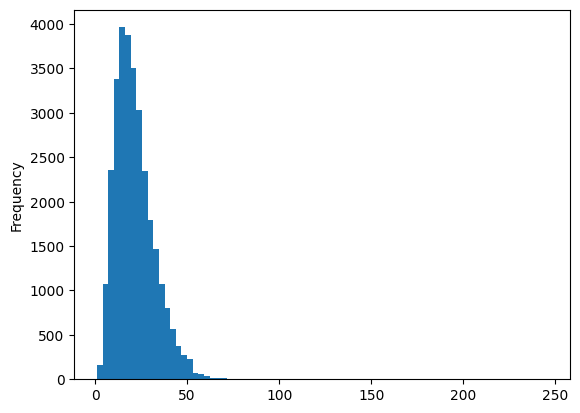

In [ ]:
lengths = []

for column in df.columns:
  out = tokenizer(df[column][df[column].notna()].tolist())
  out = [len(x) for x in out['input_ids']]
  lengths.extend(out)

lengths = pd.Series(lengths)
display(lengths.describe())
lengths.plot.hist(bins=80)

### Data class 생성

In [55]:
style_map = {
    'formal': '문어체',
    'gentle': '신사'
}

In [ ]:
class TextStyleTransferDataset(Dataset):
  def __init__(self,
               df: pd.DataFrame,
               tokenizer: Tokenizer
               ):
    self.df = df
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index, :].dropna().sample(2)
    text1 = row[0]
    text2 = row[1]
    target_style = row.index[1]
    target_style_name = style_map[target_style]

    encoder_text = f"{target_style_name} 말투로 변환:{text1}"
    decoder_text = f"{text2}{self.tokenizer.eos_token}"
    model_inputs = self.tokenizer(encoder_text, max_length=64, truncation=True)

    with self.tokenizer.as_target_tokenizer():
      labels = tokenizer(decoder_text, max_length=64, truncation=True)
    model_inputs['labels'] = labels['input_ids']
    del model_inputs['token_type_ids']

    return model_inputs

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.1, random_state=42) # train, test 분리
print(len(df_train), len(df_test))

13725 1525


In [ ]:
train_dataset = TextStyleTransferDataset(
    df_train,
    tokenizer
)
test_dataset = TextStyleTransferDataset(
    df_test,
    tokenizer
)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer, model=model
)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [ ]:
model_path = "/content/drive/MyDrive/data/text-transfer-smilegate-bart-eos/"

training_args = Seq2SeqTrainingArguments(
    output_dir=model_path,
    overwrite_output_dir=True,
    num_train_epochs=24,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_steps=500,
    save_steps=1000,
    warmup_steps=300,
    prediction_loss_only=True,
    evaluation_strategy="steps",
    save_total_limit=3
    )

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
500,2.029300,1.821229
1000,1.792600,1.752556
1500,1.625000,1.733328
2000,1.483300,1.727753
2500,1.432500,1.712313
3000,1.275200,1.743208
3500,1.227000,1.751908
4000,1.112300,1.757198
4500,1.066200,1.803071
5000,0.994900,1.789952


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

TrainOutput(global_step=20592, training_loss=0.6408213388113987, metrics={'train_runtime': 5136.7447, 'train_samples_per_second': 64.126, 'train_steps_per_second': 4.009, 'total_flos': 1.008682854746112e+16, 'train_loss': 0.6408213388113987, 'epoch': 24.0})

In [ ]:
trainer.save_model("/content/drive/MyDrive/data/text-transfer-smilegate-bart-eos/")

### 모델 학습 후 문장 변환

In [48]:
from transformers import pipeline

nlg_pipeline = pipeline('text2text-generation',model=model_path, tokenizer=model_name)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [49]:
def generate_text(pipe, text, target_style, num_return_sequences=5, max_length=60):
  target_style_name = style_map[target_style]
  text = f"{target_style_name} 말투로 변환:{text}"
  out = pipe(text, num_return_sequences=num_return_sequences, max_length=max_length)
  return [x['generated_text'] for x in out]

In [18]:
!pip install kiwipiepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.15.0-py3-none-any.whl size=30602628 sha256=95a993302830a6d65462f0724e2e211ccc3709860219d1d0808a9982e3480c0e
  Stored in directory: /root/.cache/pip/wheels/f3/55/41/ca474338ece1bc4314b01445f64ff002d71e19df45575a16e2
Successfully built kiwipiepy-model


In [19]:
from kiwipiepy import Kiwi
kiwi = Kiwi()

In [20]:
src_text = "약의 약 효과를 제대로 보려면 음식도 가려 먹어야 하는데, 특히 알레르기 약, 고혈압 약, 고지혈증 치료제 등등은 약 효과를 떨어뜨리므로 음식도 가려 먹어야 한다. 해열진통제의 대표적인 성분인 아세트아미노펜(Acetaminophen)의 경우 부작용으로 간 손상과 위장관 출혈까지 일으킬 수 있으니 반드시 피해야 한다. 알레르기 약의 주성분은 '알부테롤', '클렌부테롤' 등의 성분이 카페인을 만나면 중추신경계를 자극해 흥분, 불안, 심박수 같은 부작용을 일으킬 수 있기 때문에 기관지 천식 환자나 만성 기관지염 환자는 가급적 커피를 포함한 카페인 음료를 피하는 것이 좋다. 항히스타민제를 이루고 있는 '펙소페나딘(Fexonadine)'은 알레르기 약 성분이 흡수되는 것을 방해할 수 있어 알레르기 약 성분이 흡수되는 것을 방해할 수 있다. 우유, 요거트 등 유제품을 섭취했다면 최소 1시간은 지난 후에 약을 복용해야 하며 고혈압약X육류고혈압 약 중 하나인 '베타차단제'는 심장 박동 수를 감소시키는 약이므로 소고기·돼지고기 등 붉은 육류 섭취는 피하는 것이 좋다. 혈액의 응고 작용을 지연시키는 항응고제인 와파린은 혈전 발생 위험이 큰 사람은 혈관이 막히는 것을 방지하는 항응고제이며 특히 고혈압 환자의 경우 특별한 주의가 필요하다. 시금치· 상추· 양배추·브로콜리 등의 녹색 채소·콩 등이 함유된 자몽 주스를 섭취할 경우 약에 미치는 효과가 72시간까지 지속되므로 72시간 간격 두고 섭취할 것을 권장한다. "

In [56]:
sentences = kiwi.split_into_sents(src_text)
transfer = []

for i in sentences:
  style = "gentle"
  print("입력 문장 :", i[0])
  print("after : ", generate_text(nlg_pipeline, i[0], style, num_return_sequences=1, max_length=1000)[0])
  transfer.append(generate_text(nlg_pipeline, i[0], style, num_return_sequences=1, max_length=1000)[0])
  print('\n')

입력 문장 : 약의 약 효과를 제대로 보려면 음식도 가려 먹어야 하는데, 특히 알레르기 약, 고혈압 약, 고지혈증 치료제 등등은 약 효과를 떨어뜨리므로 음식도 가려 먹어야 한다.
after :  음식도 가려 먹어야 약의 효과를 확인할 수 있어요. 알레르기 약, 고혈압 약, 고지혈증 치료제 등은 약 효과를 떨어뜨리니까요.


입력 문장 : 해열진통제의 대표적인 성분인 아세트아미노펜(Acetaminophen)의 경우 부작용으로 간 손상과 위장관 출혈까지 일으킬 수 있으니 반드시 피해야 한다.
after :  아세트아미노펜은 간 손상과 위장관 출혈을 일으킬 수 있으므로 꼭 피하는 것이 좋습니다.


입력 문장 : 알레르기 약의 주성분은 '알부테롤', '클렌부테롤' 등의 성분이 카페인을 만나면 중추신경계를 자극해 흥분, 불안, 심박수 같은 부작용을 일으킬 수 있기 때문에 기관지 천식 환자나 만성 기관지염 환자는 가급적 커피를 포함한 카페인 음료를 피하는 것이 좋다.
after :  카페인을 만나면 기관지 천식이나 만성 기관지염이 생길 수 있으므로, 알부테롤과 클렌부테롤 성분이 결합된 알부기억제제를 피하는 것이 좋습니다.


입력 문장 : 항히스타민제를 이루고 있는 '펙소페나딘(Fexonadine)'은 알레르기 약 성분이 흡수되는 것을 방해할 수 있어 알레르기 약 성분이 흡수되는 것을 방해할 수 있다.
after :  '펙소페나딘'은 알레르기 약 성분의 흡수를 방해하여 알레르기 약의 흡수를 저해할 수 있습니다.


입력 문장 : 우유, 요거트 등 유제품을 섭취했다면 최소 1시간은 지난 후에 약을 복용해야 하며 고혈압약X육류고혈압 약 중 하나인 '베타차단제'는 심장 박동 수를 감소시키는 약이므로 소고기·돼지고기 등 붉은 육류 섭취는 피하는 것이 좋다.
after :  우유, 요거트 등 유제품을 섭취한 후에는 1시간 후에 약을 복용해야 하며, 베타차단제는 심장 박동 수를 감소시키는 약이므로 붉은 육류를 섭취하지 않는 것이 좋습니다.


입력 문장 : 혈액의 응고 작용을 지

In [57]:
transfer

['음식도 가려 먹어야 약의 효과를 확인할 수 있어요. 알레르기 약, 고혈압 약, 고지혈증 치료제 등은 약 효과를 떨어뜨리니까요.',
 '아세트아미노펜은 간 손상과 위장관 출혈을 일으킬 수 있으므로 꼭 피하는 것이 좋습니다.',
 '카페인을 만나면 기관지 천식이나 만성 기관지염이 생길 수 있으므로, 알부테롤과 클렌부테롤 성분이 결합된 알부기억제제를 피하는 것이 좋습니다.',
 "'펙소페나딘'은 알레르기 약 성분의 흡수를 방해하여 알레르기 약의 흡수를 저해할 수 있습니다.",
 '우유, 요거트 등 유제품을 섭취한 후에는 1시간 후에 약을 복용해야 하며, 베타차단제는 심장 박동 수를 감소시키는 약이므로 붉은 육류를 섭취하지 않는 것이 좋습니다.',
 '와파린은 혈전 발생 위험이 높은 사람에게 혈관이 막히는 것을 방지하는 항응고제이며, 특히 고혈압 환자에게는 특별한 주의가 필요합니다.',
 '자몽 주스에는 시금치, 상추, 양배추, 브로콜리와 같은 녹색 채소나 양배추, 그리고 브로콜리가 함유되어 있으며, 72시간 동안 섭취하면 약에 영향을 미칠 수 있으므로, 72시간 간격을 두고 섭취하시는 것을 권장합니다.']

In [60]:
df_transfer = pd.DataFrame(transfer,columns=['transfer'])
df_transfer.to_csv('요약_말투변환.csv',index=False)